### **Problem**

Predicting the high skilled players according to the scores given to the skills of football players by scouts.


In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import graphviz

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


In [2]:
attributes = pd.read_csv("../input/scotium-dataset/scoutium_attributes.csv", delimiter= ";")
potential_labels = pd.read_csv("../input/scotium-dataset/scoutium_potential_labels.csv", delimiter=";")

In [3]:
attributes.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [4]:
potential_labels.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [5]:
# merge two dataframes om öultiple columns
data = pd.merge(left= attributes, right= potential_labels, how= "left", on= ["task_response_id",  "match_id" , "evaluator_id" ,"player_id"])
df = data.copy()
df.head()


,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


### A Quick view of dataframe

In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Describe #####################")
    print(dataframe.describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.95, 0.99]).T)
    
check_df(df)

##################### Shape #####################
(10730, 9)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
potential_label      object
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id  position_id  analysis_id  attribute_id  attribute_value potential_label
0              4915     62935        177676    1361061            2     12818495          4322             56.0         average
1              4915     62935        177676    1361061            2     12818495          4323             56.0         average
2              4915     62935        177676    1361061            2     12818495          4324             67.0         average
3              4915     62935        177676    1361061        

In [7]:
# checkin missing values
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [8]:
# below_average class that is %1 of entire dataset in potential_labels

df.potential_label.value_counts() / len(df)

average          0.791892
highlighted      0.195433
below_average    0.012675
Name: potential_label, dtype: float64

In [9]:
# remove below_average class in potential_labels
df = df[df["potential_label"] != "below_average"]

In [10]:
# remove posiiton_id 1 (Goalkeeper)
df = df[df["position_id"] > 1]

In [11]:
df.shape

(9894, 9)

In [12]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [13]:
# re-formatting dataframe
new_df = pd.pivot_table(data=df,
                        index=['player_id','position_id','potential_label'],
                        columns=['attribute_id'],
                        values='attribute_value'
                        )
new_df = new_df.reset_index()
new_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [14]:
# convert column names to str
new_df.columns = new_df.columns.map(str)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   player_id        271 non-null    int64  
 1   position_id      271 non-null    int64  
 2   potential_label  271 non-null    object 
 3   4322             271 non-null    float64
 4   4323             271 non-null    float64
 5   4324             271 non-null    float64
 6   4325             271 non-null    float64
 7   4326             271 non-null    float64
 8   4327             271 non-null    float64
 9   4328             271 non-null    float64
 10  4329             271 non-null    float64
 11  4330             271 non-null    float64
 12  4332             271 non-null    float64
 13  4333             271 non-null    float64
 14  4335             271 non-null    float64
 15  4338             271 non-null    float64
 16  4339             271 non-null    float64
 17  4340            

In [15]:
# encoding the target 
label_encoder = LabelEncoder()
new_df.potential_label = label_encoder.fit_transform(new_df.potential_label)
new_df.potential_label.sample(10)

24     1
86     0
193    0
97     0
175    0
28     0
230    0
163    0
126    0
252    0
Name: potential_label, dtype: int64

count    271.000000
mean      58.367774
std       14.526790
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4322, dtype: float64


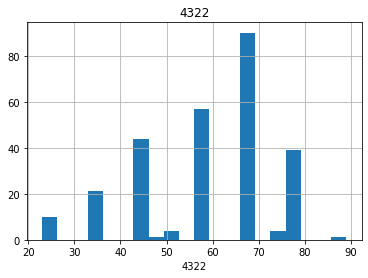

count    271.000000
mean      58.739852
std       14.757096
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       72.500000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4323, dtype: float64


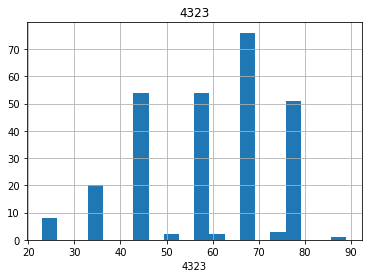

count    271.000000
mean      56.250308
std       15.868485
min       23.000000
5%        34.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4324, dtype: float64


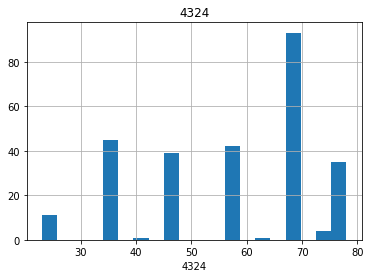

count    271.000000
mean      56.947109
std       14.749474
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4325, dtype: float64


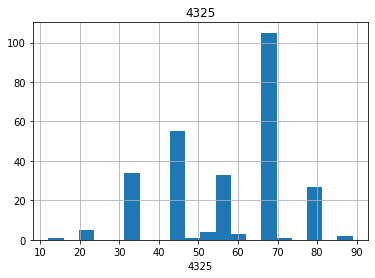

count    271.000000
mean      56.324723
std       14.799953
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4326, dtype: float64


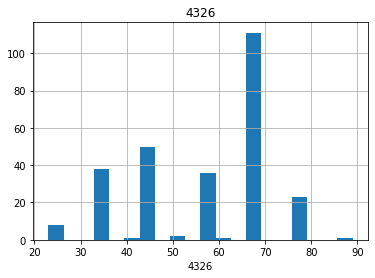

count    271.000000
mean      56.520910
std       14.522141
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4327, dtype: float64


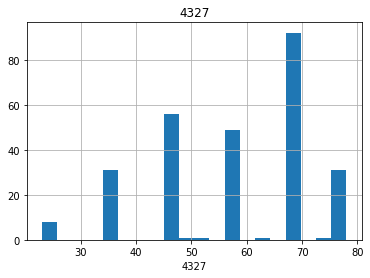

count    271.000000
mean      58.232472
std       14.610607
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4328, dtype: float64


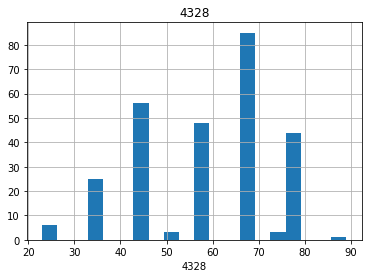

count    271.000000
mean      59.565191
std       18.433611
min       12.000000
5%        23.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       78.000000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4329, dtype: float64


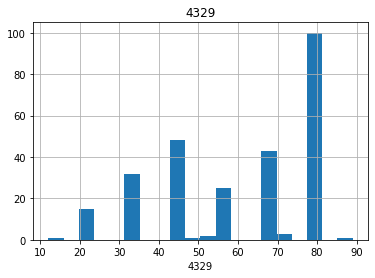

count    271.000000
mean      56.771218
std       14.076815
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       72.500000
99%       78.000000
max       89.000000
Name: 4330, dtype: float64


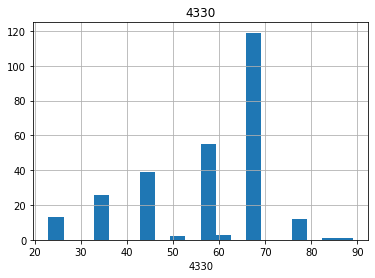

count    271.000000
mean      57.657442
std       13.542010
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4332, dtype: float64


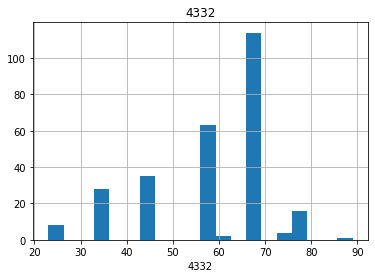

count    271.000000
mean      59.497540
std       16.369983
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       72.500000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4333, dtype: float64


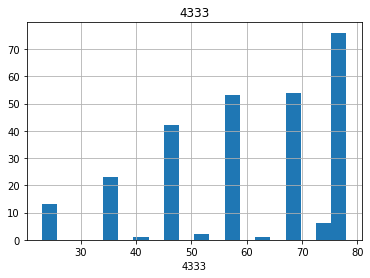

count    271.000000
mean      50.817958
std       16.269353
min       12.000000
5%        23.000000
10%       34.000000
20%       34.000000
30%       34.000000
40%       45.000000
50%       56.000000
60%       56.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       89.000000
Name: 4335, dtype: float64


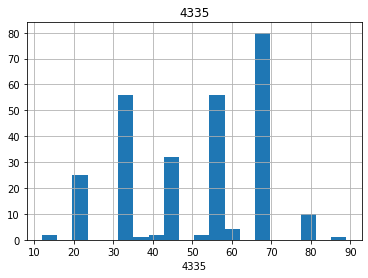

count    271.000000
mean      57.116236
std       15.670577
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4338, dtype: float64


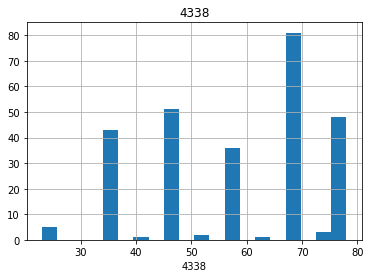

count    271.000000
mean      54.504920
std       14.894394
min       23.000000
5%        28.500000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4339, dtype: float64


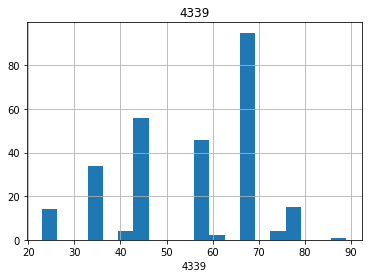

count    271.000000
mean      53.199262
std       15.161445
min       12.000000
5%        23.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       45.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4340, dtype: float64


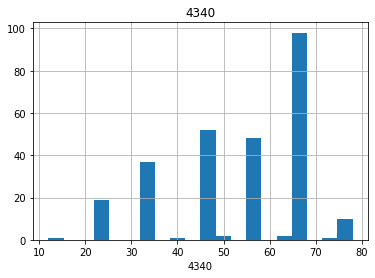

count    271.000000
mean      55.194957
std       14.794589
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4341, dtype: float64


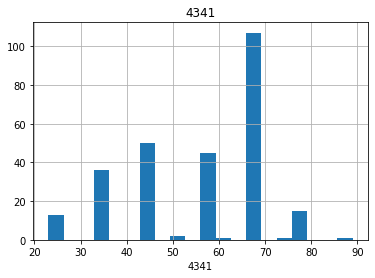

count    271.000000
mean      58.361009
std       14.718160
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4342, dtype: float64


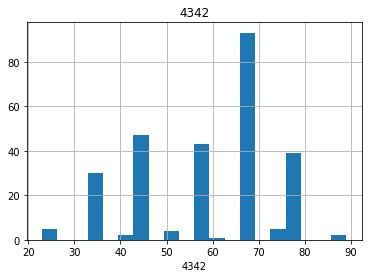

count    271.000000
mean      46.386839
std       16.790151
min       12.000000
5%        23.000000
10%       23.000000
20%       23.000000
30%       34.000000
40%       45.000000
50%       45.000000
60%       56.000000
70%       56.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       74.150000
max       89.000000
Name: 4343, dtype: float64


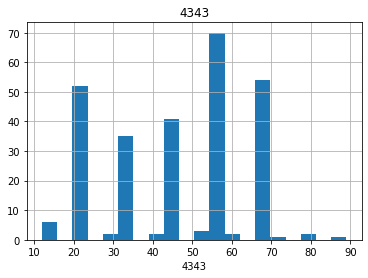

count    271.000000
mean      43.349323
std       16.909239
min       12.000000
5%        23.000000
10%       23.000000
20%       23.000000
30%       34.000000
40%       34.000000
50%       45.000000
60%       56.000000
70%       56.000000
80%       56.000000
90%       56.000000
95%       67.000000
99%       78.000000
max      100.000000
Name: 4344, dtype: float64


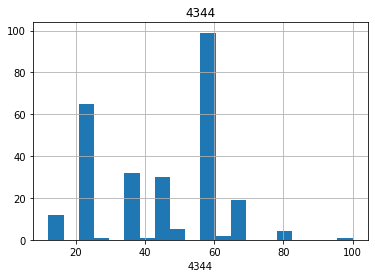

count    271.000000
mean      55.316728
std       15.768308
min       23.000000
5%        28.500000
10%       34.000000
20%       34.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       83.500000
Name: 4345, dtype: float64


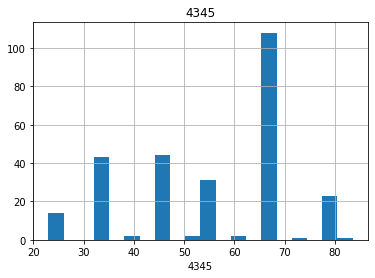

count    271.000000
mean      51.568881
std       17.591752
min       12.000000
5%        23.000000
10%       23.000000
20%       34.000000
30%       34.000000
40%       45.000000
50%       56.000000
60%       61.500000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4348, dtype: float64


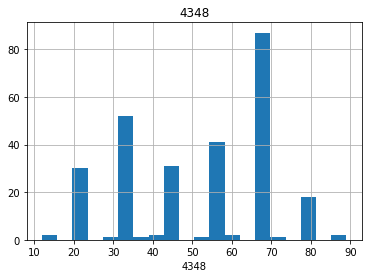

count    271.000000
mean      45.236777
std       16.095356
min       12.000000
5%        23.000000
10%       23.000000
20%       23.000000
30%       34.000000
40%       45.000000
50%       45.000000
60%       56.000000
70%       56.000000
80%       56.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       89.000000
Name: 4349, dtype: float64


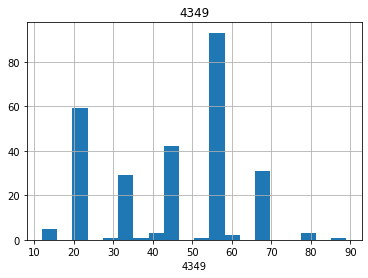

count    271.000000
mean      54.897294
std       14.302681
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4350, dtype: float64


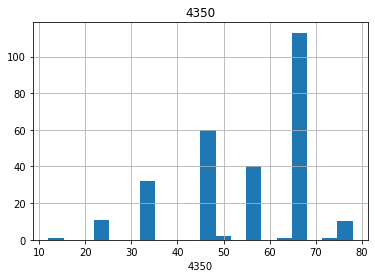

count    271.000000
mean      56.737392
std       14.344484
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max      100.000000
Name: 4351, dtype: float64


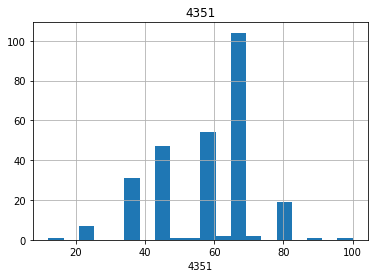

count    271.000000
mean      55.817343
std       14.243089
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4352, dtype: float64


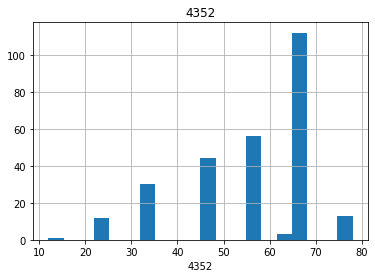

count    271.000000
mean      54.186962
std       15.776835
min       12.000000
5%        34.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       45.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4353, dtype: float64


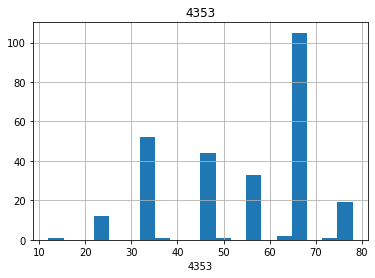

count    271.000000
mean      59.450185
std       17.652623
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       78.000000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4354, dtype: float64


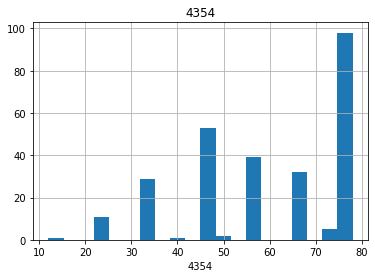

count    271.000000
mean      57.745387
std       14.677008
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4355, dtype: float64


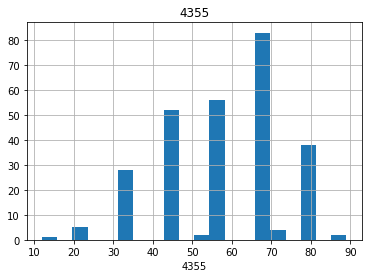

count    271.000000
mean      52.955720
std       15.378794
min       23.000000
5%        23.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       45.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4356, dtype: float64


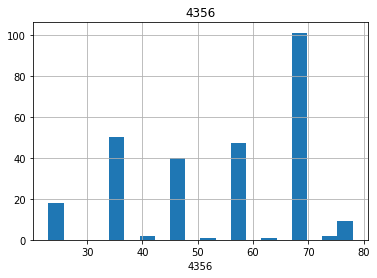

count    271.000000
mean      55.918819
std       14.450966
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       72.500000
99%       78.000000
max       78.000000
Name: 4357, dtype: float64


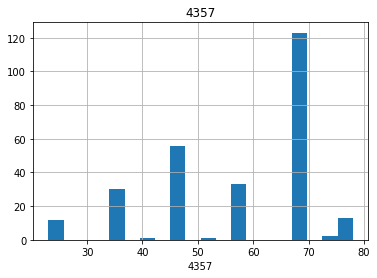

count    271.000000
mean      58.333948
std       16.391679
min        1.000000
5%        28.500000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       89.000000
max      100.000000
Name: 4407, dtype: float64


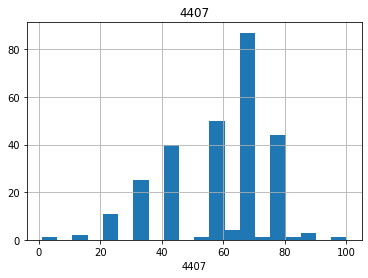

count    271.000000
mean      56.764453
std       15.334661
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4408, dtype: float64


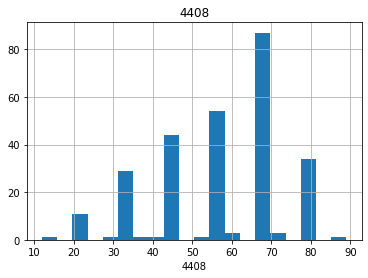

count    271.000000
mean      49.464945
std       16.217151
min       23.000000
5%        23.000000
10%       23.000000
20%       34.000000
30%       34.000000
40%       45.000000
50%       56.000000
60%       56.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4423, dtype: float64


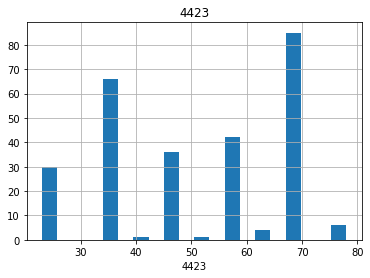

count    271.000000
mean      60.295818
std       17.028369
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       50.500000
40%       56.000000
50%       61.500000
60%       67.000000
70%       78.000000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4426, dtype: float64


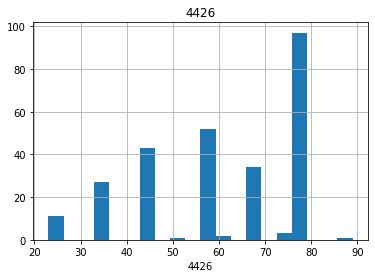

In [16]:
num_cols = new_df.columns[3:]
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(new_df, col, plot=True)

In [17]:
new_df.shape

(271, 37)

In [18]:
# scaling numeric features in order to avoid measurement problems
scaler = StandardScaler()

new_df[num_cols] = scaler.fit_transform(new_df[num_cols])
new_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,-0.791605,-0.446324,-0.122619,-1.223858,-1.035633,-1.126240,-1.009285,-0.541797,-0.690375,-0.535091,-1.067288,-1.205671,-1.004927,-1.313773,-1.041775,-0.693269,-0.435633,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,0.404075,0.727985,0.691171,0.459154,0.996474,0.631888,0.840464,0.911936,0.799406,0.588047,1.229965,0.749536,0.742305,0.878802,0.669953,0.847750,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,1.001915,0.727985,0.691171,1.132359,0.319105,0.631888,0.840464,0.911936,0.799406,0.588047,0.573607,0.749536,0.742305,0.878802,0.669953,0.077240,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,1.001915,-0.054888,0.691171,0.459154,0.996474,1.335139,1.580363,0.185069,0.799406,0.588047,-0.082751,0.097800,0.043412,0.878802,1.354645,0.847750,0.716763,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,0.404075,2.293730,1.504961,0.459154,0.996474,0.631888,0.100564,0.185069,0.799406,1.336806,0.573607,0.749536,0.742305,0.252352,1.354645,0.077240,0.716763,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


In [19]:
new_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,-0.791605,-0.446324,-0.122619,-1.223858,-1.035633,-1.126240,-1.009285,-0.541797,-0.690375,-0.535091,-1.067288,-1.205671,-1.004927,-1.313773,-1.041775,-0.693269,-0.435633,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,0.404075,0.727985,0.691171,0.459154,0.996474,0.631888,0.840464,0.911936,0.799406,0.588047,1.229965,0.749536,0.742305,0.878802,0.669953,0.847750,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,1.001915,0.727985,0.691171,1.132359,0.319105,0.631888,0.840464,0.911936,0.799406,0.588047,0.573607,0.749536,0.742305,0.878802,0.669953,0.077240,0.716763,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,1.001915,-0.054888,0.691171,0.459154,0.996474,1.335139,1.580363,0.185069,0.799406,0.588047,-0.082751,0.097800,0.043412,0.878802,1.354645,0.847750,0.716763,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,0.404075,2.293730,1.504961,0.459154,0.996474,0.631888,0.100564,0.185069,0.799406,1.336806,0.573607,0.749536,0.742305,0.252352,1.354645,0.077240,0.716763,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


In [20]:
# BASE MODELS
y = new_df["potential_label"]
X = new_df.drop(["potential_label"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state= 42)

models = [('LR', LogisticRegression()),
          ('RF', RandomForestClassifier()),
          ('SVR', SVC()),
          ('GBM', GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier()),
          ("LightGBM", LGBMClassifier()),
          ("CatBoost", CatBoostClassifier(verbose=False))]


In [21]:
def model_results(models):  
    
    base_results = pd.DataFrame()
    base_results.index = ["accuracy_score", "f1_score", "roc_auc_score", "recall_score"]
    
    for name, classifier in models:
        
        cv_results = cross_validate(classifier, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc", "recall"])
        base_results[name] = [cv_results['test_accuracy'].mean(), cv_results['test_f1'].mean(), 
                             cv_results['test_roc_auc'].mean(), cv_results['test_recall'].mean()]
        
        
    base_results = base_results.T.sort_values("f1_score", ascending=False)   
  
    return base_results


base_result = model_results(models)

In [22]:
base_result

,accuracy_score,f1_score,roc_auc_score,recall_score
LightGBM,0.888889,0.678175,0.903333,0.633333
XGBoost,0.873099,0.640952,0.897361,0.575000
RF,0.873392,0.584286,0.902917,0.450000
CatBoost,0.873392,0.583810,0.899028,0.450000
GBM,0.841228,0.513571,0.862361,0.475000
LR,0.799123,0.000000,0.502361,0.000000
SVR,0.799123,0.000000,0.443056,0.000000


In [23]:
# Hyperparameters

rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 200],
                  "colsample_bytree": [0.7, 1]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


classifiers = [('RF', RandomForestClassifier(), rf_params),
          ('GBM', GradientBoostingClassifier(), gbm_params),
          ("XGBoost", XGBClassifier(), xgboost_params),
          ("LightGBM", LGBMClassifier(), lgbm_params),
          ("CatBoost", CatBoostClassifier(verbose=False), catboost_params)]




In [24]:
#  Hyperparameter Optimization

def model_results(classifiers):  
    
    model_grid = pd.DataFrame()
    model_grid.index = ["accuracy_score", "f1_score", "roc_auc_score", "recall_score"]
    
    best_models = {}
    for name, classifier, params in classifiers:
        gs_best = GridSearchCV(classifier, params, cv=3, n_jobs=-1, verbose=False).fit(X_train, y_train)
        final_model = classifier.set_params(**gs_best.best_params_)
        cv_results = cross_validate(final_model, X_train, y_train, cv=3, scoring=["accuracy", "f1", "roc_auc", "recall"])
        model_grid[name] = [cv_results['test_accuracy'].mean(), cv_results['test_f1'].mean(), 
                             cv_results['test_roc_auc'].mean(), cv_results['test_recall'].mean()]
        
        best_models[name] = final_model   
    model_grid = model_grid.T.sort_values("f1_score", ascending=False)   
  
    return model_grid, best_models
final_model, best_model_params = model_results(classifiers)

In [25]:
final_model

,accuracy_score,f1_score,roc_auc_score,recall_score
LightGBM,0.899471,0.695375,0.857976,0.576923
XGBoost,0.883598,0.629630,0.885594,0.497863
RF,0.888889,0.622222,0.882673,0.470085
CatBoost,0.888889,0.620635,0.882457,0.470085
GBM,0.873016,0.615954,0.865824,0.523504


In [26]:
base_result

,accuracy_score,f1_score,roc_auc_score,recall_score
LightGBM,0.888889,0.678175,0.903333,0.633333
XGBoost,0.873099,0.640952,0.897361,0.575000
RF,0.873392,0.584286,0.902917,0.450000
CatBoost,0.873392,0.583810,0.899028,0.450000
GBM,0.841228,0.513571,0.862361,0.475000
LR,0.799123,0.000000,0.502361,0.000000
SVR,0.799123,0.000000,0.443056,0.000000


In [27]:
best_model_params

{'RF': RandomForestClassifier(max_depth=8, max_features=5, min_samples_split=8,
                        n_estimators=500),
 'GBM': GradientBoostingClassifier(subsample=0.7),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=500, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...),
 'LightGBM': LGBMClassifier(colsample_bytree=1, learning_rate=0.01

In [28]:
final_lgbm = LGBMClassifier(colsample_bytree=1, learning_rate=0.01, n_estimators=1000).fit(X_train, y_train)
y_pred = final_lgbm.predict(X_test)
y_prob = final_lgbm.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_prob)

0.8411458333333334

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        64
           1       0.89      0.44      0.59        18

    accuracy                           0.87        82
   macro avg       0.88      0.71      0.76        82
weighted avg       0.87      0.87      0.85        82



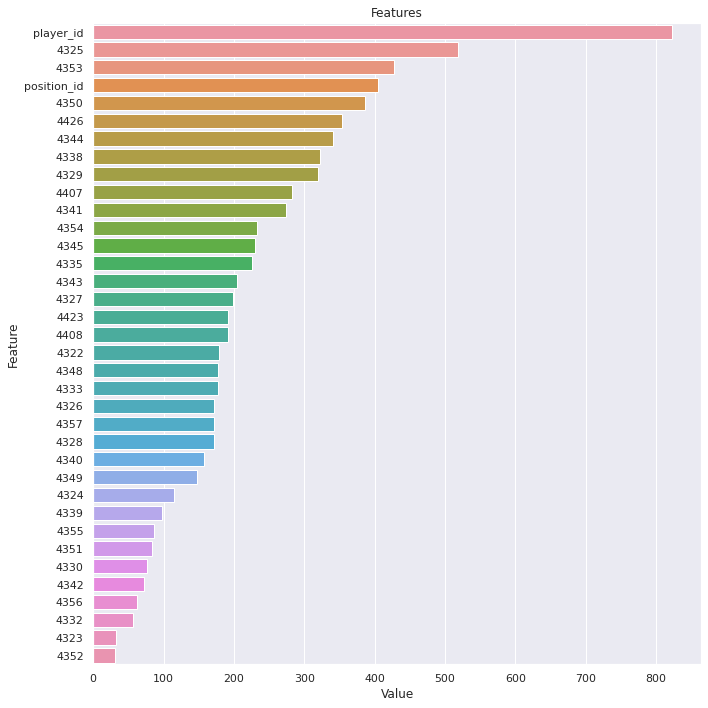

In [30]:
# feature importance
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(final_lgbm, X)

In [31]:
lgbm_val_params = ["learning_rate", [0.01, 0.1]],\
                ["n_estimators", [100, 300, 500, 1000]],\
                ["colsample_bytree", [0.5, 0.7, 1]]


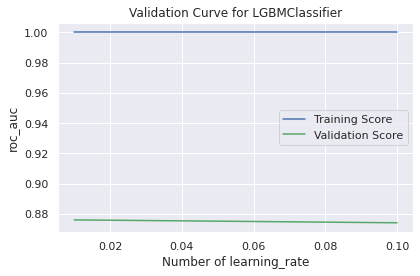

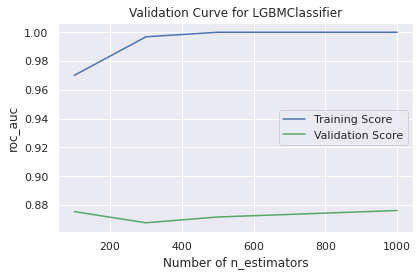

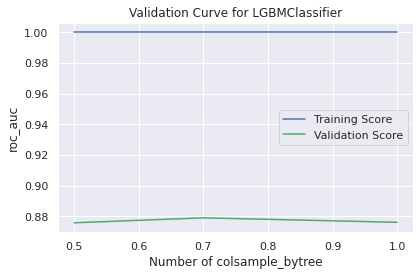

In [32]:
# Analyzing Model Complexity with Learning Curves
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()



for i in range(len(lgbm_val_params)):
    val_curve_params(final_lgbm, X, y, lgbm_val_params[i][0], lgbm_val_params[i][1])